# Milestone 3
Grant Perkins

## Summary of Process
### Business Problem
Can the reliability of the MBTA Red Line be predicted using data from other rapid transit lines?
### Data Manipulation
#### Data Cleaning
There were a few missing data points (<3%). I interpolated the missing data in each column by inserting the median value for that column. Otherwise, the data was very clean.
#### Data Wrangling
In its raw form, the MBTA reliability dataset has a row for each rapid transit reading every day. This means on a given monday, there is a row for the red line, a row for the blue line, etc. In the below code, I transform the dataset by having one row for each day, and columns for each of the rapid transit lines.

I also prepare my dataset labels by dividing the `Red_Numerator` column by the `Red_Denominator` column, resulting in a measure of how reliable the red line was each day. The mean of these labels is ~90% reliability, so I define a train being on time as being >90% reliable, and a train being late as <90% reliable. I am training the model as a regression problem, simply due to how arbitrary my 90% threshold is. To calculate accuracy, I will simply compare predictions with my threshold, then calculate accuracy instead of a regression metric.
### EDA
I looked at missing data, outliers, distributions of my data for each column, summary statistics, and correlation between variables. Most of my work went into correlation analyis, where I made a correlation matrix, scatter plots, and line plots of multiple variables.

## Research Question
Can features be derived from the MBTA's reliability dataset to classify whether the Red Line Rapid Transit will be late during peak hours to at least 75% accuracy?

## Analysis Approach
I was unsuccessful in producing a model that could make intelligent predictions, but it was not for the lack of trying. You will see my attempts below.
### Feature Engineering
I made two datasets, one for small ML models from scikit-learn, and another dataset for recurrent neural networks written in PyTorch.
For both datasets, I min/max scale each column so my values are between 0 and 1. Then, I use a sliding/rolling window approach to generate 30 day time series to predict on.
#### scikit-learn Dataset FE
Each window is `30 days X 14 columns`. This is too many features for a model such as an SVM to learn, so I will do some dimension reduction to have a more reasonable dataset. My approach is that for each column, I fit a low-degree polynomial and use the coefficients as features. Using a 3rd degree polynomial, each window ends up being `4 coefficients (3 + intercept) X 14 columns`.
#### PyTorch Dataset FE
Each window is `30 days X 14 columns`. This is perfectly fine for deep learning approaches. I do no feature engineering here.

### Modeling
I have tried a few models so far:
- Support Vector Machine (SVM)
- Long Short Term Memory model (LSTM)
- Gated Recurrent Unit model (GRU)

### Performance Evaluation
I will use the below metrics to evaluate my models.
#### Classification metrics
- Accuracy
- Macro F1 score
- Precision
- Recall
Honestly, I'm just using scikit-learn's classification report function.
#### Model loss
I'm using MSE loss for my deep learning models while training. I am evaluating training and validation loss.

## Preliminary results

I'm going to use the metrics defined above. I'm also going to make ROC plots. First step: define DNN models.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.svm
import sklearn.metrics
import torch
from torch import nn

from dataset import MBTADataset

In [2]:
class LSTM(nn.Module):
    """
    LSTM regression model using PyTorch
    """

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Create LSTM model
        :param input_size: number of input features
        :param hidden_size: size of hidden layer
        :param num_layers: number of recurrent layers
        :param output_size: output neurons
        """
        super().__init__()
        self.hidden_dim = hidden_size
        self.layer_dim = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                           dropout=0.1)  # add a little bit of dropout to encourage growth
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  # make output [0, 1]
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        """
        Predict!
        :param x: input
        :return: prediction
        """
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, x):
        """
        Initialize hidden layers with random weights.
        Need to explore random versus zeros, see if it makes a difference.
        :param x: input tensor
        :return: h and c tensors
        """
        h0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cpu() for t in (h0, c0)]

In [3]:
class GRU(nn.Module):
    """
    GRU regression model using PyTorch
    """

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Create GRU model
        :param input_size: number of input features
        :param hidden_size: size of hidden layer
        :param num_layers: number of recurrent layers
        :param output_size: output neurons
        """
        super().__init__()
        self.hidden_dim = hidden_size
        self.layer_dim = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,
                          dropout=0.1)  # add a little bit of dropout to encourage growth
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  # make output [0, 1]
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        """
        Predict!
        :param x: input
        :return: prediction
        """
        h0 = self.init_hidden(x)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, x):
        """
        Initialize hidden layers with random weights.
        Need to explore random versus zeros, see if it makes a difference.
        :param x: input tensor
        :return: h tensor
        """
        return torch.randn(self.layer_dim, x.size(0), self.hidden_dim).cpu()

With models defined, now I have to set up functions to train and evaluate the models.

In [4]:
def train_and_evaluate_SVM(mbta_dataset: MBTADataset):
    """
    Train and evaluate sklearn's SVM
    :param mbta_dataset: MBTADataset object.
    :return: nothing. prints classification report.
    """
    train_X, train_y, test_X, test_y = mbta_dataset.make_sklearn_dataset()
    model = sklearn.svm.SVR(kernel="rbf")
    model.fit(train_X, train_y)
    preds = model.predict(test_X) < 0.9
    truths = test_y < 0.9
    print(sklearn.metrics.classification_report(truths, preds))

In [5]:
def train_torch_model(train_loader, val_loader, model: nn.Module, optimizer, loss_func, model_name):
    """
    Train a PyTorch model to its lowest validation loss.
    Stop training when loss has not been reduced after 100 epochs.
    :param train_loader: train dataset loader
    :param val_loader: validation dataset loader
    :param model: a PyTorch model.
    :param optimizer: optimization function
    :param loss_func: loss function
    :param model_name: name of model to save file to
    :return: train and validation loss as a dictionary
    """
    print('Start model training')
    best_loss = 10  # set a ridiculously high loss to start with
    patience, trials = 100, 0  # track how long it's been since loss has improved
    losses = {"train": [], "val": [], "epoch": []}
    epoch = 0

    while trials < patience:  # train loop!
        epoch += 1
        epoch_train_losses = []  # collect batch losses
        for i, (x_batch, y_batch) in enumerate(train_loader):
            model.train()
            x_batch = x_batch.cpu()
            y_batch = y_batch.cpu()
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_func(out, y_batch)  # calculate loss
            epoch_train_losses.append(loss.detach().numpy())
            loss.backward()  # gradient descent
            optimizer.step()  # apply gradients

        # calculate validation loss
        model.eval()
        epoch_val_losses = []
        for x_val, y_val in val_loader:
            x_val, y_val = [t.cpu() for t in (x_val, y_val)]
            out = model(x_val)
            loss = loss_func(out, y_val)
            epoch_val_losses.append(loss.detach().numpy())

        epoch_val_loss = np.stack(epoch_val_losses).ravel().mean()  # average validation loss
        epoch_train_loss = np.stack(epoch_train_losses).ravel().mean()  # average train loss
        losses["val"].append(epoch_val_loss)
        losses["train"].append(epoch_train_loss)
        losses["epoch"].append(epoch)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}. Train loss: {epoch_train_loss:.7f}. Validation loss: {epoch_val_loss:.7f}")

        if epoch_val_loss < best_loss:
            trials = 0
            best_loss = epoch_val_loss
            torch.save(model.state_dict(), f'{model_name}.pth')
            print(f'Saved Epoch: {epoch} with validation loss: {best_loss:.7f}')
        else:
            trials += 1

    print(f'Early stopping on epoch {epoch}')
    return losses

In [13]:
def evaluate_torch_model(test_loader, model: nn.Module, model_name):
    """
    Evaluate torch model with classification metrics
    :param test_loader:
    :param model:
    :param model_name:
    :return:
    """
    model.load_state_dict(torch.load(f"{model_name}.pth")) # load saved weights
    model.eval()
    # compare ground truths against predictions
    truths = []
    predictions = []
    for x_val, y_val in test_loader:
        x_val, y_val = [t.cpu() for t in (x_val, y_val)]
        truths.extend(y_val.numpy().tolist())
        out = model(x_val)
        predictions.extend(out.detach().numpy().tolist())
    # convert confidences to classes
    truths = np.array(truths) < 0.9
    predictions = np.array(predictions) < 0.9
    # classification metrics
    print(sklearn.metrics.classification_report(truths, predictions))

In [7]:
def plot_torch_training_results(model_name, losses):
    """
    Plot train and validation losses
    :param model_name: name of model
    :param losses: loss dict
    :return: None
    """
    plt.plot(losses["epoch"], losses["train"], label="Training Loss")
    plt.plot(losses["epoch"], losses["val"], label="Validation Loss")
    plt.title(f"Model Loss for {model_name}")
    plt.legend()
    plt.show()

Time to get some results! I will be interpreting them after each code block.

In [8]:
window_size = 21
dataset = MBTADataset(window_size)
train_loader, val_loader, test_loader = dataset.make_torch_dataset()

1068 samples in train set
356 samples in val set
356 samples in test set


/home/grant/code/CS539FinalProject/dataset.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_df[col] = (series - series.min()) / (series.max() - series.min())


#### SVM Training and Evaluation

In [9]:
train_and_evaluate_SVM(dataset)

1424 samples in train set
356 samples in test set
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       189
        True       0.47      1.00      0.64       167

    accuracy                           0.47       356
   macro avg       0.23      0.50      0.32       356
weighted avg       0.22      0.47      0.30       356



/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Needless to say, the SVM performed very poorly. It did not predict the red line to late even once. All number here are meaningless, other than the 0% precision, recall, and macro-f1 score for the `False` class. I initially suspected this could be due to very high dimensional data, that may be too difficult to find trends in for a simple model. This unfortunately is not the case, as we see more results.

#### GRU Training and Evaluation

In [10]:
input_dim = 14
hidden_dim = 64
layer_dim = 5
output_dim = 1
lr = 0.0001
n_epochs = 1000

In [11]:
gru = GRU(input_dim, hidden_dim, layer_dim, output_dim)
gru = gru.to("cpu")
loss_function = nn.MSELoss()
optimizer_function = torch.optim.Adam(gru.parameters(), lr=lr)
gru_name = "GRU"
gru_losses = train_torch_model(train_loader, val_loader, gru, optimizer_function, loss_function, gru_name)

Start model training
Saved Epoch: 1 with validation loss: 0.0011831
Epoch: 10. Train loss: 0.0041881. Validation loss: 0.0036817
Epoch: 20. Train loss: 0.0037379. Validation loss: 0.0034073
Epoch: 30. Train loss: 0.0035672. Validation loss: 0.0023946
Epoch: 40. Train loss: 0.0033650. Validation loss: 0.0017263
Epoch: 50. Train loss: 0.0034445. Validation loss: 0.0010963
Saved Epoch: 50 with validation loss: 0.0010963
Saved Epoch: 52 with validation loss: 0.0010937
Saved Epoch: 54 with validation loss: 0.0010527
Saved Epoch: 55 with validation loss: 0.0010430
Saved Epoch: 56 with validation loss: 0.0009226
Saved Epoch: 59 with validation loss: 0.0009222
Epoch: 60. Train loss: 0.0034006. Validation loss: 0.0009409
Saved Epoch: 61 with validation loss: 0.0008854
Saved Epoch: 63 with validation loss: 0.0008103
Epoch: 70. Train loss: 0.0032771. Validation loss: 0.0008548
Saved Epoch: 72 with validation loss: 0.0007979
Saved Epoch: 73 with validation loss: 0.0007975
Saved Epoch: 75 with vali

The training results for the GRU are promising. It definitely converged on some set of weights.

In [14]:
evaluate_torch_model(test_loader, gru, gru_name)

              precision    recall  f1-score   support

       False       0.53      1.00      0.69       189
        True       0.00      0.00      0.00       167

    accuracy                           0.53       356
   macro avg       0.27      0.50      0.35       356
weighted avg       0.28      0.53      0.37       356



/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Once again, a model failed to predict a class at all in the test set. This is a failure. All values other than the 0's are meaningless. Let's see our loss curves.

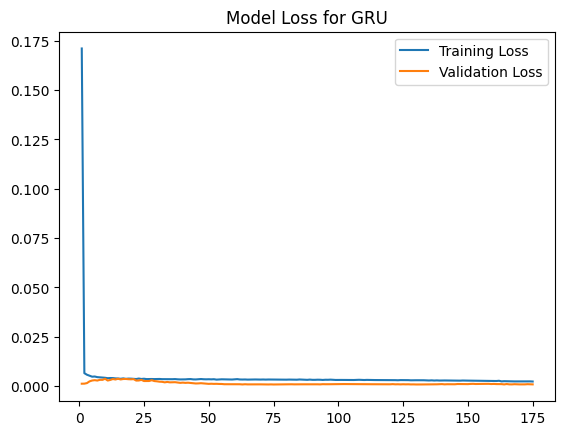

In [17]:
plot_torch_training_results(gru_name, gru_losses)

It does seem that something was in fact learned in the data, and there is no evidence of overfitting. I'm not sure why the loss is so close to 0, and also so lacking in change.

#### LSTM Training and Evaluation

In [15]:
lstm = LSTM(input_dim, hidden_dim, layer_dim, output_dim)
lstm = lstm.to("cpu")
loss_function = nn.MSELoss()
optimizer_function = torch.optim.Adam(gru.parameters(), lr=lr)
lstm_name = "LSTM"
lstm_losses = train_torch_model(train_loader, val_loader, lstm, optimizer_function, loss_function, lstm_name)

Start model training
Saved Epoch: 1 with validation loss: 0.7462776
Saved Epoch: 8 with validation loss: 0.7462743
Epoch: 10. Train loss: 0.7087370. Validation loss: 0.7462814
Epoch: 20. Train loss: 0.7083657. Validation loss: 0.7462766
Epoch: 30. Train loss: 0.7085381. Validation loss: 0.7462783
Epoch: 40. Train loss: 0.7084448. Validation loss: 0.7462819
Epoch: 50. Train loss: 0.7086563. Validation loss: 0.7462801
Epoch: 60. Train loss: 0.7085920. Validation loss: 0.7462791
Epoch: 70. Train loss: 0.7086384. Validation loss: 0.7462813
Epoch: 80. Train loss: 0.7084001. Validation loss: 0.7462831
Epoch: 90. Train loss: 0.7086503. Validation loss: 0.7462809
Epoch: 100. Train loss: 0.7085876. Validation loss: 0.7462788
Early stopping on epoch 108


Right off the back, it is clear that the model is not converging. I would not waste time evaluating this model, but I already have the functions written.

In [16]:
evaluate_torch_model(test_loader, lstm, lstm_name)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       189
        True       0.47      1.00      0.64       167

    accuracy                           0.47       356
   macro avg       0.23      0.50      0.32       356
weighted avg       0.22      0.47      0.30       356



/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grant/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As expected, the LSTM did not predict a class at all. All numbers other than 0 are meaningless in this table. Honestly, I have never successfully used an LSTM in any project. Maybe I have an inherent misunderstanding of how it is used, but I am confused because my GRU did converge.

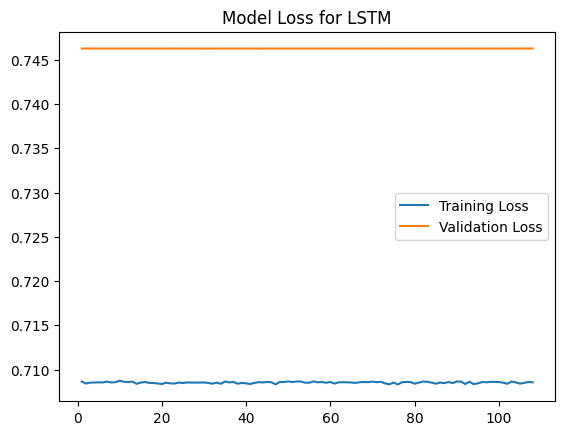

In [18]:
plot_torch_training_results(lstm_name, lstm_losses)

Finally, we have some perfectly level loss plots. This is disappointing.

### Summary of results, approaches, etc.

The code we see above is the result of my week of experimentation. I tried a variety of hyperparameters including learning rates, optimizers, hidden layers, layer sizes, but was unable to find success. I made changes to the dataset including testing whether the inclusion or exclusion of historical Red Line in the input would make an impact on the result metrics. I tried using different degree polynomials for the SVM. Unfortunately, I was unable to get anything working intelligently. I did not waste my time making ROC curves or any extra pretty visuals, as I consistently on predicted one class regardless of what model I was training. I put a substantial amount of time into this project, as shown in both this notebook and `dataset.py`. I had to get PyTorch working on my computer to even do this project, as well as learn about GRU and LSTM architectures, and how to use them on a custom dataset.

## Looking Forward

### Scale
I may include weather data for each day, such as rainfall and wind, to see if that will give additional insight. I'm sure I can find a free API for it. I will continue to use the data I am already using.

### Model Complexity
I will continue to explore different models, including small models such as Random Forest and larger ones like CNNs built for time series forecasting. I am also thinking about new feature engineering techniques, like passing summary statistics for each time period as input. Interested in more ideas, though.

### Tools
They are already being used. I already have PyTorch set up, as well as of course scikit-learn. The models take about 5/10 minutes to train to 200 epochs.

## Obstacles
 - The first one is of course I have no promising results. This is a major obstacle that I am working on.
 - I'm not sure what to do for evaluation entirely. Currently I'm doing an admittedly strange regression --> classification approach, which makes it difficult to produce ROC curves